In [1]:
import pandas as pd
import numpy as np
import os

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import forestplot as fp # https://dev.to/lsys/making-coefficient-plots-in-python-using-forestplot-7i7
from scipy.stats import pearsonr

import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
# set seaborn style
sns.set_style("whitegrid")

import sys
from transforms import rank_INT
from bullseye import bullseye_plot, get_cmap_center

In [3]:
# made in 00_trait_correlation.ipynb
traits_cov_health = pd.read_csv('data/phenotypes_48k_99CMR_13other_cov_noCM.csv', index_col=0)
# made with src/transfroms.py
traits_cov_rIVT = pd.read_csv('data/phenotypes_48k_99CMR_13other_rIVT.csv', index_col=0)
# keep only the index in traits_cov_health
traits_cov_rIVT = traits_cov_rIVT.loc[traits_cov_health.index]
print(traits_cov_health.shape, traits_cov_rIVT.shape)

(40058, 130) (40058, 73)


# Violin plots show the distribution by Sex 

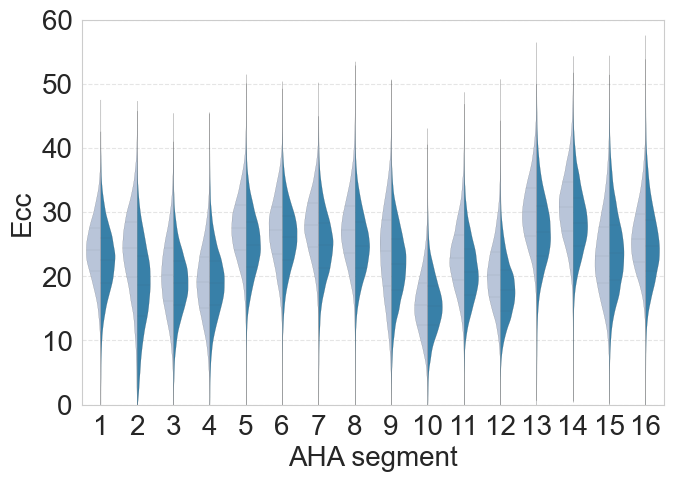

In [4]:
plt.rcParams['font.family'] = ['Arial']
# font size
plt.rcParams.update({'font.size': 20})

# distribution just for Ecc
def plot_distribution(traitid, ymin, ymax):
    # data to plot is traits_cov_health WT_AHA_? values merged
    plot_sample = pd.melt(traits_cov_health, id_vars=['Sex'], value_vars=['{}_AHA_{}'.format(traitid, x) for x in range(1, 17)], value_name='value')
    plot_sample['value'] = - plot_sample.value
    plot_sample = plot_sample.assign(AHA=plot_sample.variable.str.split('_').str[-1])
    # rename Sex 0 to Female, 1 to Male
    plot_sample.loc[plot_sample.Sex==0, 'Sex'] = 'Female'
    plot_sample.loc[plot_sample.Sex==1, 'Sex'] = 'Male'

    # violin plot
    fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
    sns.violinplot(
        data=plot_sample, 
        x = 'AHA',
        y = 'value',

        hue='Sex', hue_order=None, orient=None, color=None, palette='PuBu', saturation=0.75, fill=True, 
        
        inner='quart', 
        split=True, width=0.8, dodge='auto', gap=0.1, linewidth=0.1, linecolor='auto', cut=0, gridsize=100, 
        
        bw_method='scott', bw_adjust=1, density_norm='area', common_norm=False, hue_norm=None, formatter=None, log_scale=None, native_scale=False, 
        
        legend=False, 

        ax=ax
    )

    # ax.set_title('WT distribution by AHA segment')
    ax.set_xlabel('AHA segment')
    ax.set_ylabel(traitid)
    ax.set_ylim(ymin, ymax)
    # grid lines
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    # legend remove
    ax.legend().remove()
    fig.savefig('data/SI_01_distribution_by_AHA_{}.pdf'.format(traitid), bbox_inches='tight')
plot_distribution('Ecc', 0, 60)

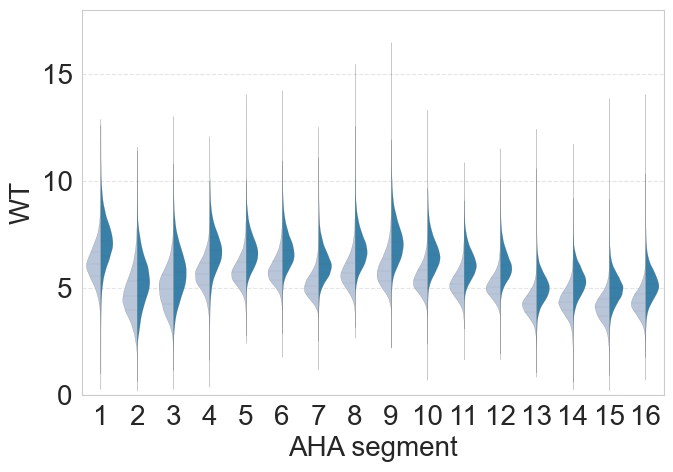

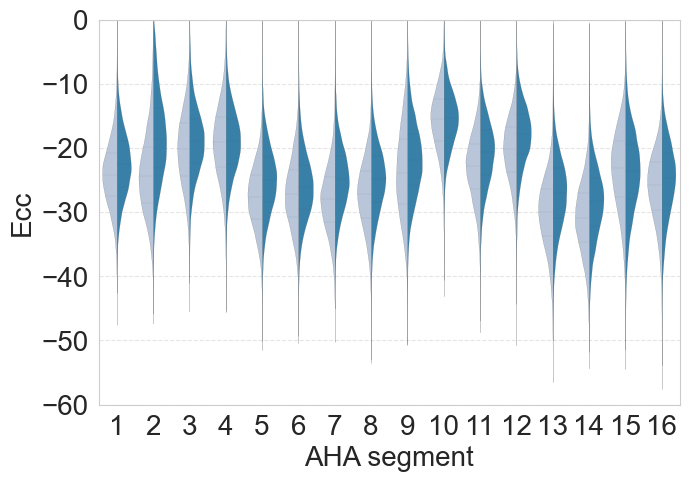

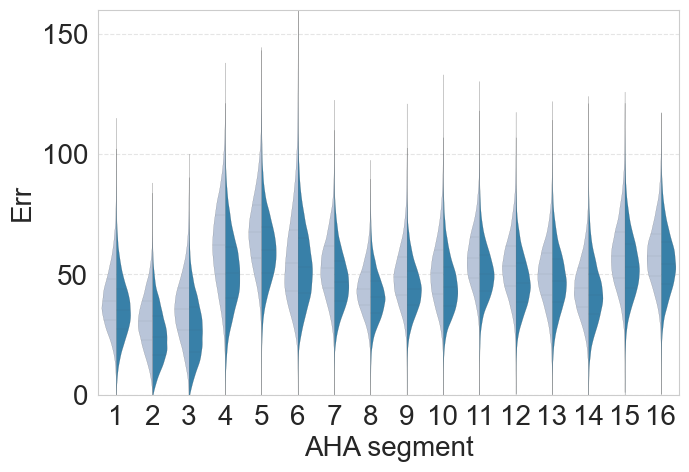

In [7]:
plt.rcParams['font.family'] = ['Arial']
# font size
plt.rcParams.update({'font.size': 20})

# distribution
def plot_distribution(traitid, ymin, ymax):
    # data to plot is traits_cov_health WT_AHA_? values merged
    plot_sample = pd.melt(traits_cov_health, id_vars=['Sex'], value_vars=['{}_AHA_{}'.format(traitid, x) for x in range(1, 17)], value_name='value')
    plot_sample = plot_sample.assign(AHA=plot_sample.variable.str.split('_').str[-1])
    # rename Sex 0 to Female, 1 to Male
    plot_sample.loc[plot_sample.Sex==0, 'Sex'] = 'Female'
    plot_sample.loc[plot_sample.Sex==1, 'Sex'] = 'Male'

    # violin plot
    fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
    sns.violinplot(
        data=plot_sample, 
        x = 'AHA',
        y = 'value',

        hue='Sex', hue_order=None, orient=None, color=None, palette='PuBu', saturation=0.75, fill=True, 
        
        inner='quart', 
        split=True, width=0.8, dodge='auto', gap=0.1, linewidth=0.1, linecolor='auto', cut=0, gridsize=100, 
        
        bw_method='scott', bw_adjust=1, density_norm='area', common_norm=False, hue_norm=None, formatter=None, log_scale=None, native_scale=False, 
        
        legend=False, 

        ax=ax
    )

    # ax.set_title('WT distribution by AHA segment')
    ax.set_xlabel('AHA segment')
    ax.set_ylabel(traitid)
    ax.set_ylim(ymin, ymax)
    # grid lines
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    # legend remove
    ax.legend().remove()
    fig.savefig('data/SI_01_distribution_by_AHA_{}.pdf'.format(traitid), bbox_inches='tight')
plot_distribution('WT', 0, 18)
plot_distribution('Ecc', -60, 0)
plot_distribution('Err',0, 160)

# Heatmap Pearson's correlation matrix

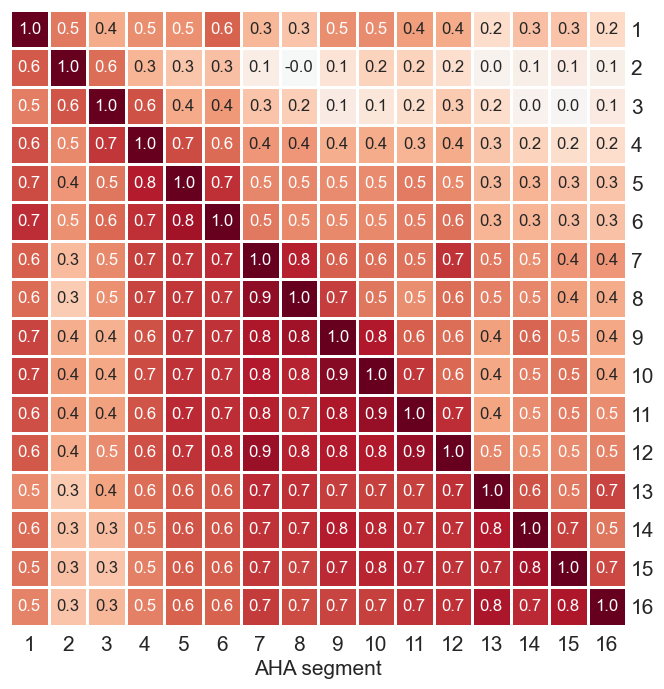

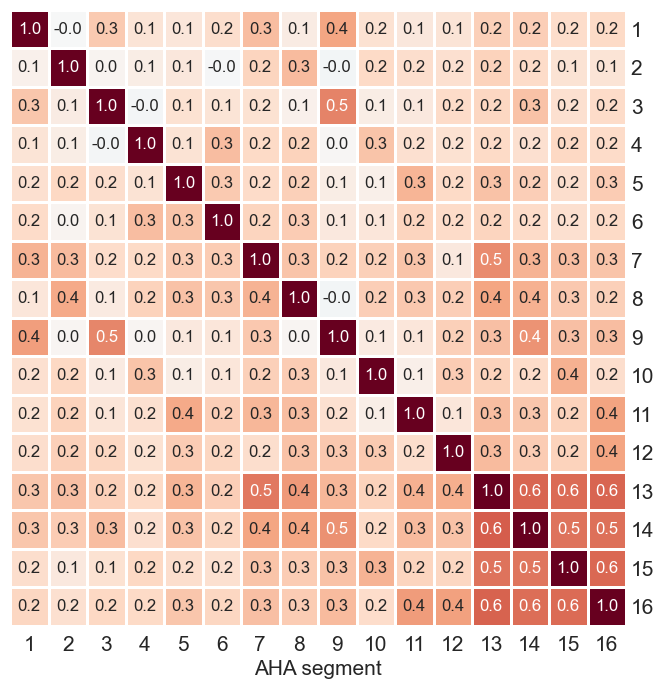

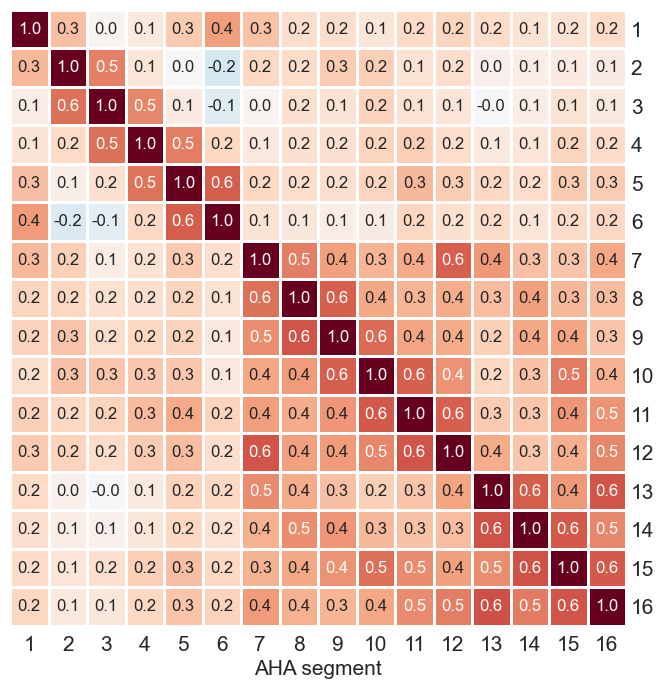

In [4]:
# Correlation: heatmap by trait and AHA segment
pheno_zscore = pd.read_csv('phenotypes_48k_99CMR_13other_rIVT_noCM_zscorebySexAgeBSA2BP.csv', index_col=0)
for trait in ['WT','Ecc','Err']:
    # raw
    raw_corr = traits_cov_rIVT[[f'{trait}_AHA_{i}' for i in range(1,17)]].rename(columns={f'{trait}_AHA_{i}':f'{i}' for i in range(1,17)}).corr()
    # adjusted 
    adjusted_corr = pheno_zscore[[f'{trait}_AHA_{i}' for i in range(1,17)]].rename(columns={f'{trait}_AHA_{i}':f'{i}' for i in range(1,17)}).corr()
    # merge them together where the upper triangle is raw and lower triangle is adjusted
    corr = pd.DataFrame(np.tril(raw_corr), columns=raw_corr.columns, index=raw_corr.index)
    # set the diagonal to 0
    corr = corr - np.diag(np.diag(corr))
    corr = corr + pd.DataFrame(np.triu(adjusted_corr), columns=adjusted_corr.columns, index=adjusted_corr.index)

    # plot corr heatmap
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    sns.heatmap(corr, cmap=sns.color_palette('RdBu_r', as_cmap=True), vmin=-1, vmax=1, square=True, linewidths=1, linecolor='white', ax=ax, annot=True, fmt='.1f', annot_kws={'size': 12})
    # yticks turn horizontal
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    # yticks and labels on the right side only
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.tick_params(axis='y', which='both', length=0)
    # x axis label
    ax.set_xlabel('AHA segment', fontsize=15)
    # set ticks size
    ax.tick_params(axis='both', which='major', labelsize=15)

    # no color bar
    ax.collections[0].colorbar.remove()
    fig.savefig(f'data/SI_01_correlation_by_AHA_{trait}.pdf', bbox_inches='tight')

In [ ]:
# Correlation: boxplots for overview.
pheno_zscore_bsa = pd.read_csv('pheno_99/phenotypes_48k_99CMR_13other_rIVT_noCM_zscorebySexAgeBSA.csv', index_col=0)
pheno_zscore_bp = pd.read_csv('pheno_99/phenotypes_48k_99CMR_13other_rIVT_noCM_zscorebySexAgeBSA2BP.csv', index_col=0)
all_corr = pd.DataFrame()
for trait in ['WT','Ecc','Err']:
    # raw
    raw_corr = traits_cov_rIVT[[f'{trait}_AHA_{i}' for i in range(1,17)]].rename(columns={f'{trait}_AHA_{i}':f'{i}' for i in range(1,17)}).corr()
    # flatten the upper triangle (exclude diagonal)
    raw_corr = raw_corr.where(np.triu(np.ones(raw_corr.shape), 1).astype(np.bool))
    raw_corr = raw_corr.stack().reset_index()
    raw_corr.columns = ['seg1', 'seg2', 'corr']
    raw_corr['trait'] = trait
    raw_corr['type'] = 'original'
    # adjusted 
    adjusted_corr = pheno_zscore_bsa[[f'{trait}_AHA_{i}' for i in range(1,17)]].rename(columns={f'{trait}_AHA_{i}':f'{i}' for i in range(1,17)}).corr()
    # flatten the upper triangle (exclude diagonal)
    adjusted_corr = adjusted_corr.where(np.triu(np.ones(adjusted_corr.shape), 1).astype(np.bool))
    adjusted_corr = adjusted_corr.stack().reset_index()
    adjusted_corr.columns = ['seg1', 'seg2', 'corr']
    adjusted_corr['trait'] = trait
    adjusted_corr['type'] = 'afterbsa'
    corr = pd.concat([raw_corr, adjusted_corr])
    # adjusted 
    adjusted_corr = pheno_zscore_bp[[f'{trait}_AHA_{i}' for i in range(1,17)]].rename(columns={f'{trait}_AHA_{i}':f'{i}' for i in range(1,17)}).corr()
    # flatten the upper triangle (exclude diagonal)
    adjusted_corr = adjusted_corr.where(np.triu(np.ones(adjusted_corr.shape), 1).astype(np.bool))
    adjusted_corr = adjusted_corr.stack().reset_index()
    adjusted_corr.columns = ['seg1', 'seg2', 'corr']
    adjusted_corr['trait'] = trait
    adjusted_corr['type'] = 'afterbp'
    # merge them together
    corr = pd.concat([corr, adjusted_corr])
    all_corr = pd.concat([all_corr, corr])

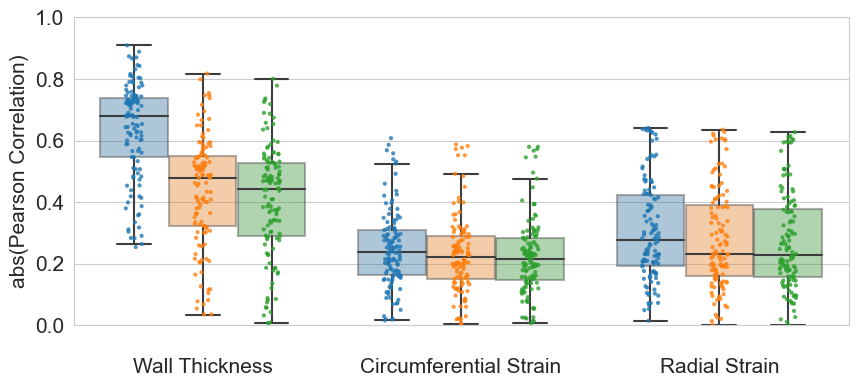

In [46]:
# # Correlation: boxplots for overview.

# all_corr['corr'] = all_corr['corr'].apply(abs)
plt.rcParams['font.family'] = ['Arial']
# boxplot all_corr
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.boxplot(data=all_corr, x='trait', y='corr', hue='type', hue_order=['original','afterbsa','afterbp'],
            palette=sns.color_palette(n_colors=3), boxprops={'alpha': 0.4},
             saturation=0.75, width=0.8, dodge=True, fliersize=0, ax=ax)
sns.stripplot(data=all_corr, x='trait', y='corr', hue='type', hue_order=['original','afterbsa','afterbp'],
              palette=sns.color_palette(n_colors=3), size=3, alpha=0.8,
              dodge=True, ax=ax)

ax.set_ylabel('abs(Pearson Correlation)', fontsize=15)
ax.set_xlabel('')
# set ticks size
ax.tick_params(axis='both', which='major', labelsize=15)
# set xticks label
ax.set_xticklabels(['Wall Thickness', 'Circumferential Strain', 'Radial Strain'])
ax.set_ylim(0, 1)
# increase padding for x ticklabels
ax.tick_params(axis='x', pad=20)

# # legend remove title
# ax.legend(title=None)
# # set legend size
# ax.legend(fontsize=12)
## remove legend
ax.legend().remove()
fig.savefig('data/SI_01_correlation_by_AHA_boxplot.pdf', bbox_inches='tight')

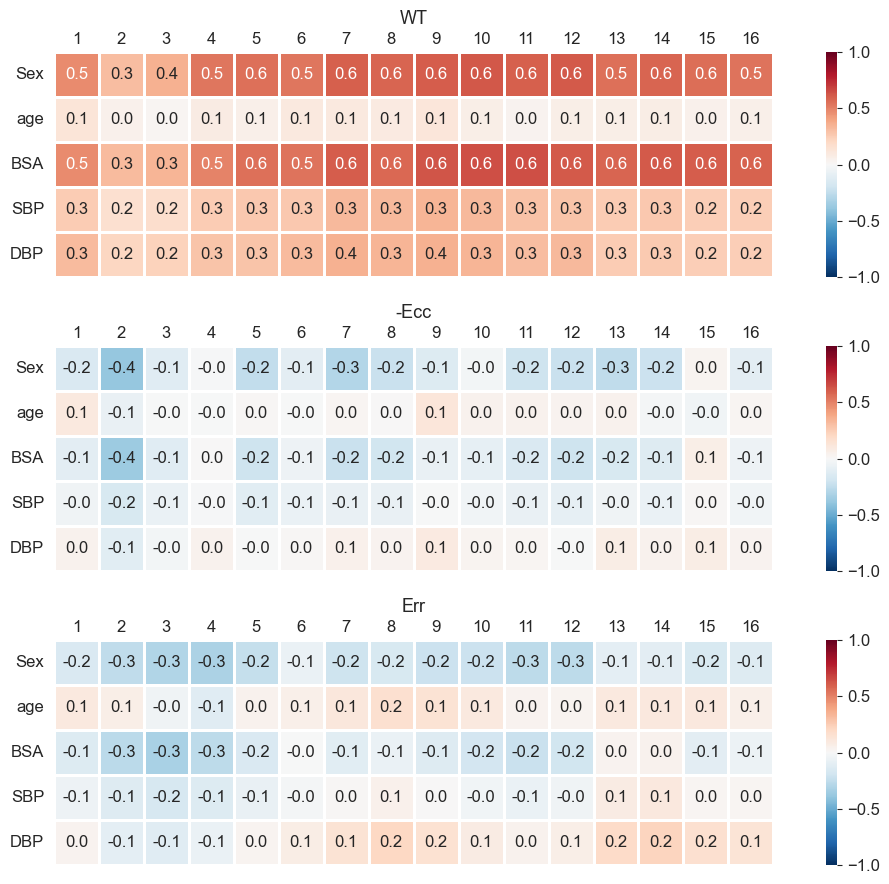

In [33]:
# traits_cov_rIVT = pd.read_csv('phenotypes_48k_99CMR_13other_rIVT.csv', index_col=0)
# pheno_zscore = pd.read_csv('phenotypes_48k_99CMR_13other_rIVT_noCM_zscorebySexAgeBSA2BP.csv', index_col=0)

# # Ecc = -Ecc
# for i in range(1,17):
#     pheno_zscore[f'Ecc_AHA_{i}'] = -pheno_zscore[f'Ecc_AHA_{i}']
#     traits_cov_rIVT[f'Ecc_AHA_{i}'] = -traits_cov_rIVT[f'Ecc_AHA_{i}']
    
fig, ax = plt.subplots(3, 1, figsize=(11, 9))
# tick labels size
plt.rcParams.update({'font.size': 12})
# each row is a trait
# each column is before and after adjustment
for i, trait in enumerate(['WT','Ecc','Err']):
    xlabels = [f'{trait}_AHA_{i}' for i in range(1,17)]
    ylabels = ['Sex', 'age_at_MRI', 'BSA', 'SBP_at_MRI', 'DBP_at_MRI']
    # raw
    raw_correlations = traits_cov_rIVT[xlabels+ylabels].corr()[xlabels].loc[ylabels]
    # plot corr heatmap
    sns.heatmap(raw_correlations, cmap=sns.color_palette('RdBu_r', as_cmap=True), vmin=-1, vmax=1, square=True, linewidths=1, linecolor='white', annot=True, fmt='.1f', annot_kws={'size': 12},
                ax=ax[i])
    # yticks turn horizontal
    ax[i].set_yticklabels(ax[i].get_yticklabels(), rotation=0)
    # x ticks on the top and turn horizontal
    ax[i].xaxis.tick_top()
    ax[i].xaxis.set_label_position("top")
    ax[i].tick_params(axis='x', which='both', length=0)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=0)
    # set x ticks label
    ax[i].set_xticklabels([x.split('_')[-1] for x in xlabels])
    # set y ticks label
    ax[i].set_yticklabels([x.split('_')[0] for x in ylabels])
    # set title
    if trait =='Ecc':
        trait = '-Ecc'
    ax[i].set_title(f'{trait}', fontsize=13)
plt.tight_layout()
fig.savefig('data/SI_01_correlation_by_AHA_trait_cov.pdf', bbox_inches='tight')

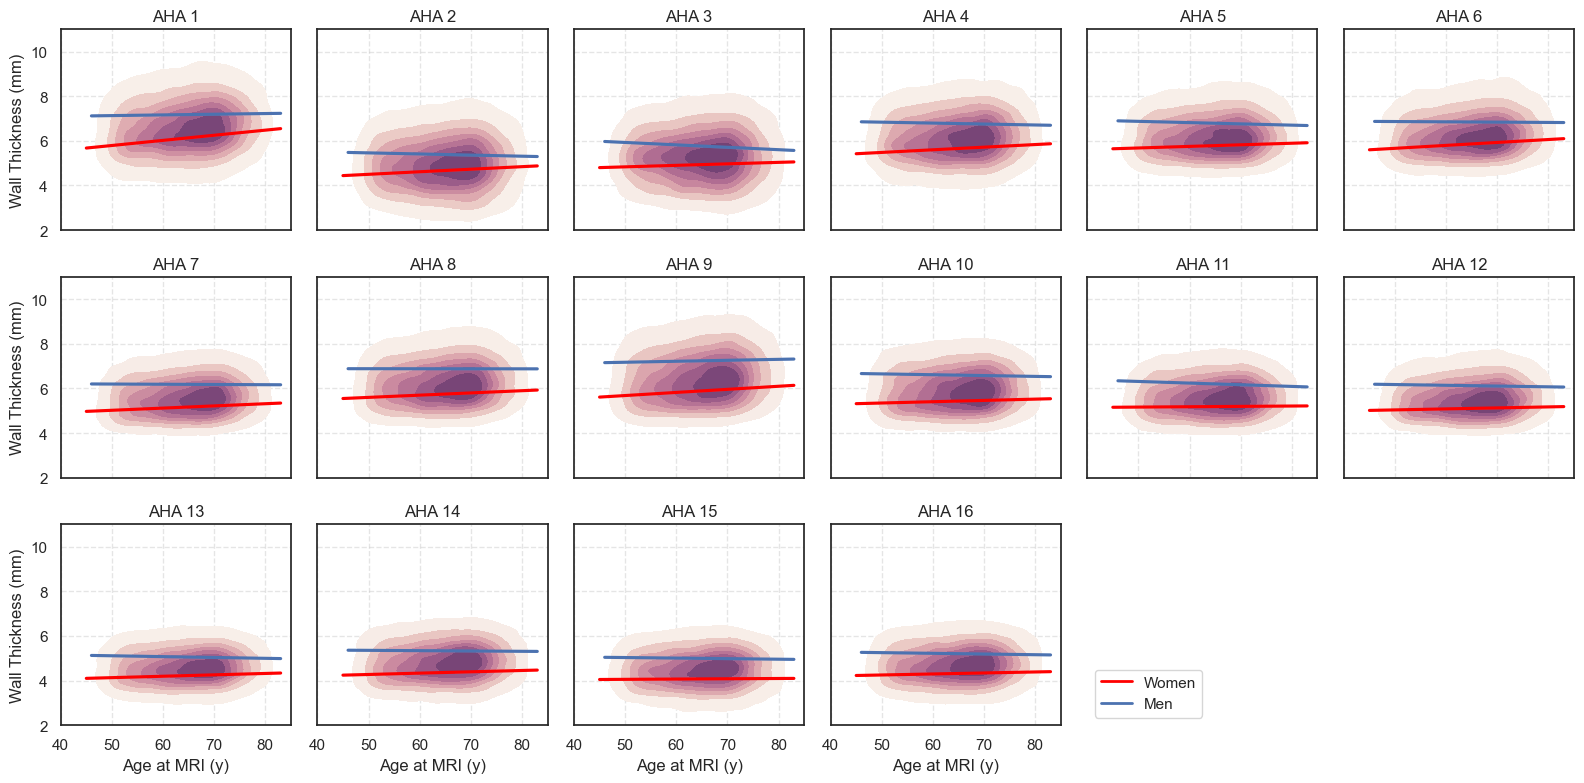

In [4]:
from matplotlib.lines import Line2D

sns.set_theme(style="white")

red='red'
blue=sns.color_palette()[0]

# Set up the matplotlib figure
fig, axes = plt.subplots(3,6, figsize=(16, 8), sharex=True, sharey=True)

# select random 10000 lines from the dataframe traits_cov_rIVT
# plot_sample = traits_cov_rIVT.sample(n=2000, random_state=1)
# plot_sample = traits_cov_health.sample(n=500, random_state=1)
plot_sample = traits_cov_health

cmap=sns.cubehelix_palette(start=0, light=1, dark=0.3, as_cmap=True)

# Rotate the starting point around the cubehelix hue circle
for ax, s in zip(axes.flat, range(1,17)):
    sns.kdeplot(
    data=plot_sample, 
    x='age_at_MRI', y='WT_AHA_{}'.format(s), 
    fill=True,cmap=cmap, levels=8,
    ax=ax,
    )
    # plot regression line
    sns.regplot(
    data=plot_sample[plot_sample.Sex==0], # women
    x='age_at_MRI', y='WT_AHA_{}'.format(s),
    scatter=False,
    ax=ax, color=red,
    )
    sns.regplot(
    data=plot_sample[plot_sample.Sex==1], # men
    x='age_at_MRI', y='WT_AHA_{}'.format(s),
    scatter=False,
    ax=ax, color=blue,
    )
    ax.set_title('AHA {}'.format(s))
    ax.set_ylabel('Wall Thickness (mm)')
    ax.set_xlabel('Age at MRI (y)')
    # grid lines
    ax.grid(True, linestyle='--', alpha=0.5)

# add legend in empty axes
axes.flat[16].axis('off')
# male blue line, female red line
axes.flat[16].legend(
    handles=[
        Line2D([], [], color=red, lw=2, label='Women'),
        Line2D([], [], color=blue, lw=2, label='Men')
    ], 
    loc='lower left',
)
axes.flat[17].axis('off')

ax.set(xlim=(40, 85), ylim=(2, 11))
# f.subplots_adjust(0, 0, 1, 1, .08, .08)
fig.tight_layout()
fig.savefig('data/01_trait_correlation_WT_AHA_Age.pdf', bbox_inches='tight')


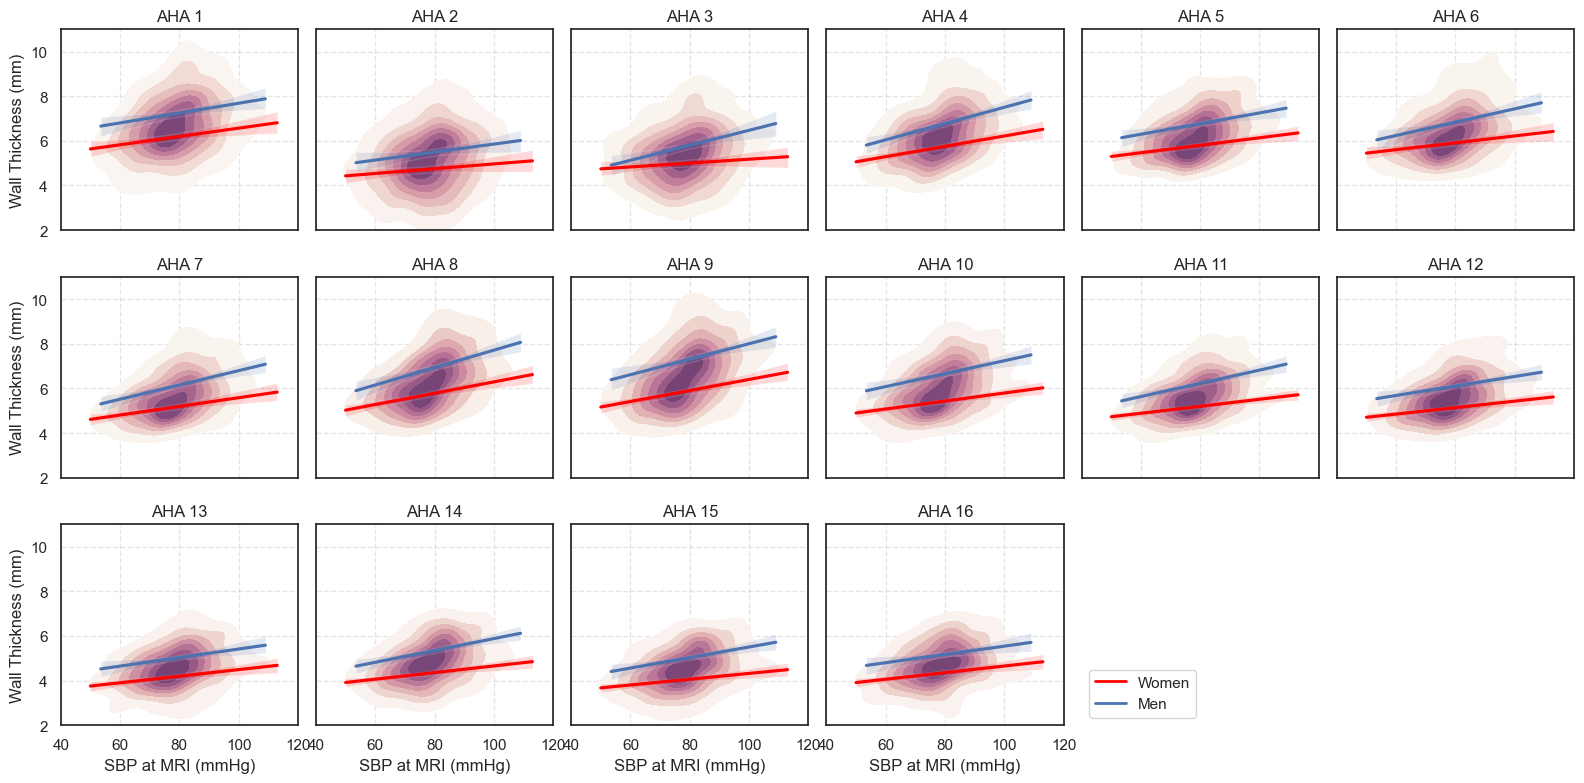

In [6]:
from matplotlib.lines import Line2D

sns.set_theme(style="white")

red='red'
blue=sns.color_palette()[0]

# Set up the matplotlib figure
fig, axes = plt.subplots(3,6, figsize=(16, 8), sharex=True, sharey=True)

# select random 10000 lines from the dataframe traits_cov_rIVT
# plot_sample = traits_cov_rIVT.sample(n=2000, random_state=1)
plot_sample = traits_cov_health.sample(n=500, random_state=1)

cmap=sns.cubehelix_palette(start=0, light=1, dark=0.3, as_cmap=True)

# Rotate the starting point around the cubehelix hue circle
for ax, s in zip(axes.flat, range(1,17)):
    sns.kdeplot(
    data=plot_sample, 
    x='SBP_at_MRI', y='WT_AHA_{}'.format(s), 
    fill=True,cmap=cmap, levels=8,
    ax=ax,
    )
    # plot regression line
    sns.regplot(
    data=plot_sample[plot_sample.Sex==0], # women
    x='SBP_at_MRI', y='WT_AHA_{}'.format(s),
    scatter=False,
    ax=ax, color=red,
    )
    sns.regplot(
    data=plot_sample[plot_sample.Sex==1], # men
    x='SBP_at_MRI', y='WT_AHA_{}'.format(s),
    scatter=False,
    ax=ax, color=blue,
    )
    ax.set_title('AHA {}'.format(s))
    ax.set_ylabel('Wall Thickness (mm)')
    ax.set_xlabel('SBP at MRI (mmHg)')
    # grid lines
    ax.grid(True, linestyle='--', alpha=0.5)

# add legend in empty axes
axes.flat[16].axis('off')
# male blue line, female red line
axes.flat[16].legend(
    handles=[
        Line2D([], [], color=red, lw=2, label='Women'),
        Line2D([], [], color=blue, lw=2, label='Men')
    ], 
    loc='lower left',
)
axes.flat[17].axis('off')

# ax.set(xlim=(40, 85), ylim=(2, 10))
ax.set(xlim=(40, 120), ylim=(2, 11))
# f.subplots_adjust(0, 0, 1, 1, .08, .08)
fig.tight_layout()
fig.savefig('data/01_trait_correlation_WT_AHA_SBP.pdf', bbox_inches='tight')

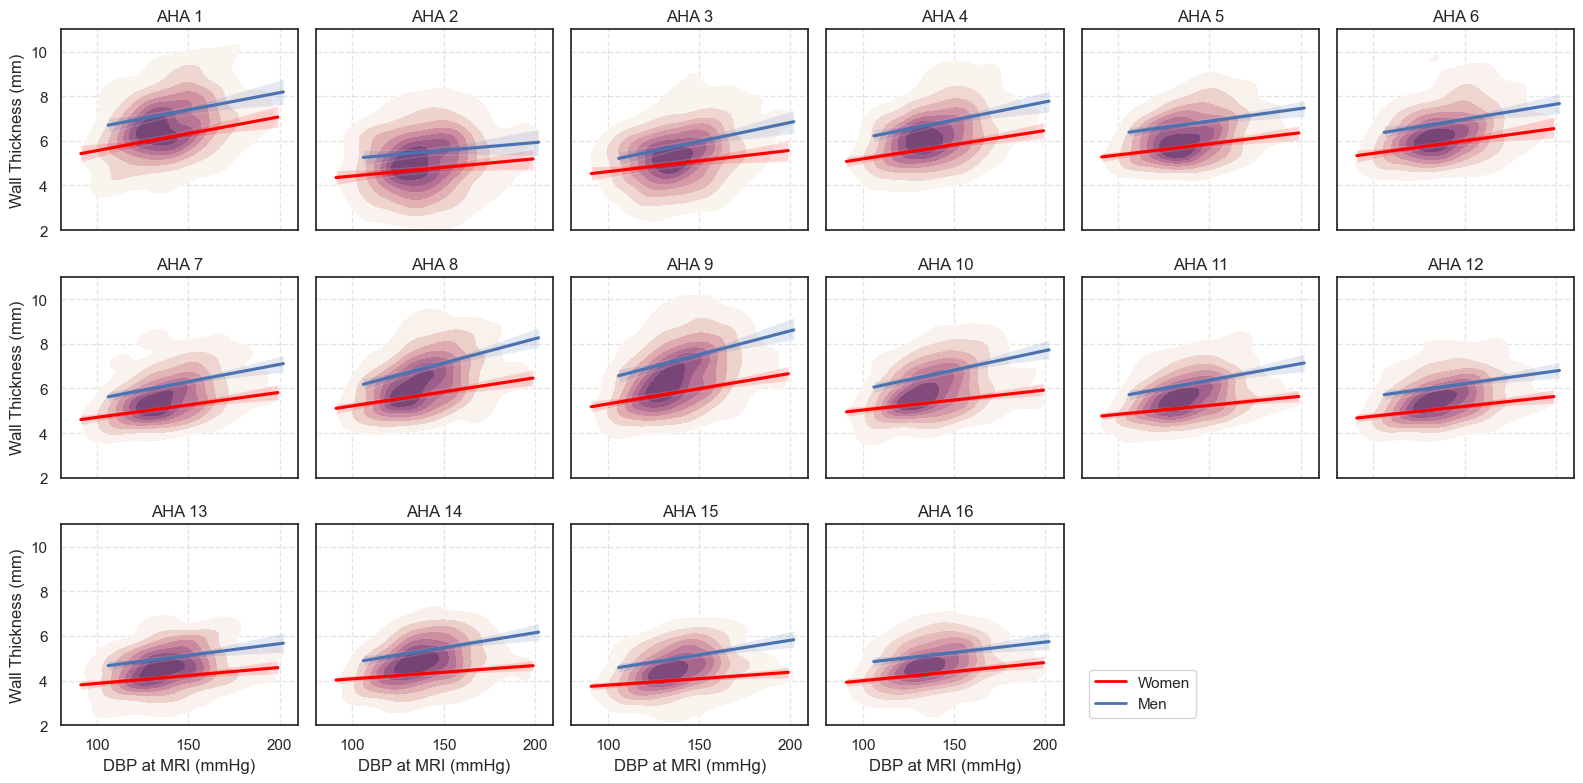

In [10]:
from matplotlib.lines import Line2D

sns.set_theme(style="white")

red='red'
blue=sns.color_palette()[0]

# Set up the matplotlib figure
fig, axes = plt.subplots(3,6, figsize=(16, 8), sharex=True, sharey=True)

# select random 10000 lines from the dataframe traits_cov_rIVT
# plot_sample = traits_cov_rIVT.sample(n=2000, random_state=1)
plot_sample = traits_cov_health.sample(n=500, random_state=1)

cmap=sns.cubehelix_palette(start=0, light=1, dark=0.3, as_cmap=True)

# Rotate the starting point around the cubehelix hue circle
for ax, s in zip(axes.flat, range(1,17)):
    sns.kdeplot(
    data=plot_sample, 
    x='DBP_at_MRI', y='WT_AHA_{}'.format(s), 
    fill=True,cmap=cmap, levels=8,
    ax=ax,
    )
    # plot regression line
    sns.regplot(
    data=plot_sample[plot_sample.Sex==0], # women
    x='DBP_at_MRI', y='WT_AHA_{}'.format(s),
    scatter=False,
    ax=ax, color=red,
    )
    sns.regplot(
    data=plot_sample[plot_sample.Sex==1], # men
    x='DBP_at_MRI', y='WT_AHA_{}'.format(s),
    scatter=False,
    ax=ax, color=blue,
    )
    ax.set_title('AHA {}'.format(s))
    ax.set_ylabel('Wall Thickness (mm)')
    ax.set_xlabel('DBP at MRI (mmHg)')
    # grid lines
    ax.grid(True, linestyle='--', alpha=0.5)

# add legend in empty axes
axes.flat[16].axis('off')
# male blue line, female red line
axes.flat[16].legend(
    handles=[
        Line2D([], [], color=red, lw=2, label='Women'),
        Line2D([], [], color=blue, lw=2, label='Men')
    ], 
    loc='lower left',
)
axes.flat[17].axis('off')

ax.set(xlim=(80, 210), ylim=(2, 11))
# f.subplots_adjust(0, 0, 1, 1, .08, .08)
fig.tight_layout()
fig.savefig('data/01_trait_correlation_WT_AHA_DBP.pdf', bbox_inches='tight')

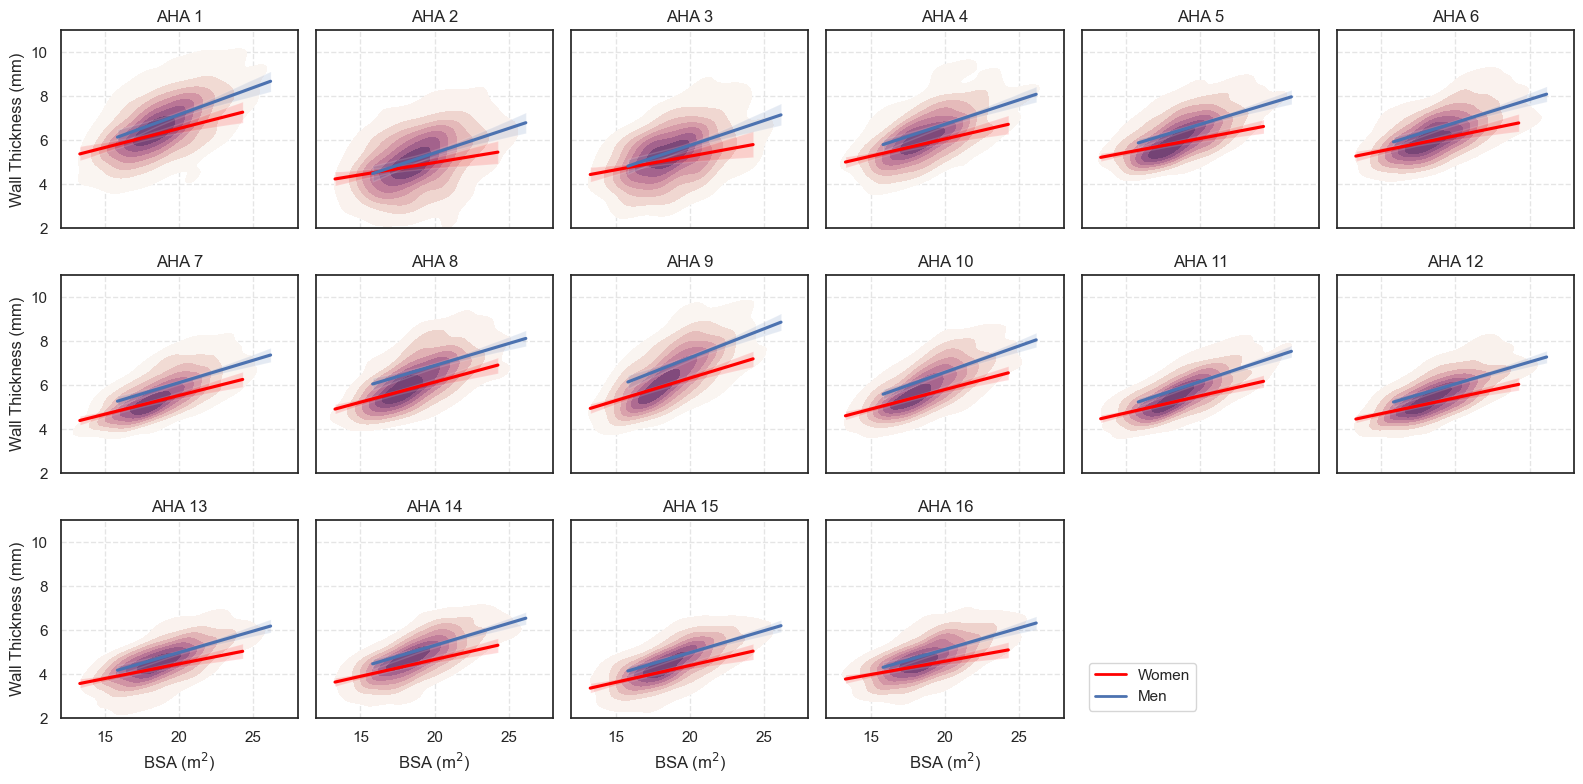

In [11]:
from matplotlib.lines import Line2D

sns.set_theme(style="white")

red='red'
blue=sns.color_palette()[0]

# Set up the matplotlib figure
fig, axes = plt.subplots(3,6, figsize=(16, 8), sharex=True, sharey=True)

# select random 10000 lines from the dataframe traits_cov_rIVT
# plot_sample = traits_cov_rIVT.sample(n=2000, random_state=1)
plot_sample = traits_cov_health.sample(n=500, random_state=1)

cmap=sns.cubehelix_palette(start=0, light=1, dark=0.3, as_cmap=True)

# Rotate the starting point around the cubehelix hue circle
for ax, s in zip(axes.flat, range(1,17)):
    sns.kdeplot(
    data=plot_sample, 
    x='BSA', y='WT_AHA_{}'.format(s), 
    fill=True,cmap=cmap, levels=8,
    ax=ax,
    )
    # plot regression line
    sns.regplot(
    data=plot_sample[plot_sample.Sex==0], # women
    x='BSA', y='WT_AHA_{}'.format(s),
    scatter=False,
    ax=ax, color=red,
    )
    sns.regplot(
    data=plot_sample[plot_sample.Sex==1], # men
    x='BSA', y='WT_AHA_{}'.format(s),
    scatter=False,
    ax=ax, color=blue,
    )
    ax.set_title('AHA {}'.format(s))
    ax.set_ylabel('Wall Thickness (mm)')
    ax.set_xlabel('BSA (m$^2$)')
    # grid lines
    ax.grid(True, linestyle='--', alpha=0.5)

# add legend in empty axes
axes.flat[16].axis('off')
# male blue line, female red line
axes.flat[16].legend(
    handles=[
        Line2D([], [], color=red, lw=2, label='Women'),
        Line2D([], [], color=blue, lw=2, label='Men')
    ], 
    loc='lower left',
)
axes.flat[17].axis('off')

ax.set(xlim=(12, 28), ylim=(2, 11))
# f.subplots_adjust(0, 0, 1, 1, .08, .08)
fig.tight_layout()
fig.savefig('data/01_trait_correlation_WT_AHA_BSA.pdf', bbox_inches='tight')